In [11]:
#!pip install --upgrade yfinance


### 1. What the columns mean?

For each trading day:

- Open → the price at the first trade of the session.

- High → the highest price reached during the session.

- Low → the lowest price reached during the session.

- Close → the price at the last trade of the session.

- Volume → number of shares traded that day.

So those are the “raw OHLCV” fields.

### 2. “Close” vs “Adjusted Close”

Close = the literal last traded price that day.

Adjusted Close (Adj Close) = Close price corrected for corporate actions like:

$Adj Close_t = Close_t × Adjustment Factor_t$

where the adjustment factor is cumulative product of split/dividend adjustments.

👉 Adj Close is what you want for backtests and VaR because it gives a smooth, consistent return series. If you use raw Close, you’ll see artificial jumps on split/dividend dates.

# Step 1: Load Prices

In [25]:
import yfinance as yf

ticker = "AAPL"
data_original = yf.download(ticker, start="2015-01-01", end="2025-01-01", auto_adjust=False)

print(data_original.columns)
print(data_original.head())


[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2015-01-02  24.261049  27.332500  27.860001  26.837500  27.847500  212818400
2015-01-05  23.577572  26.562500  27.162500  26.352501  27.072500  257142000
2015-01-06  23.579800  26.565001  26.857500  26.157499  26.635000  263188400
2015-01-07  23.910431  26.937500  27.049999  26.674999  26.799999  160423600
2015-01-08  24.829126  27.972500  28.037500  27.174999  27.307501  237458000


In [32]:
# Extract 'Adj Close' from MultiIndex 
# Keep it as a DataFrame
adj_close_df = data_original.loc[:, [('Adj Close', 'AAPL')]]  # still MultiIndex
adj_close_df.columns = ['Adj Close']  # flatten column name

print(adj_close_df.head())


            Adj Close
Date                 
2015-01-02  24.261049
2015-01-05  23.577572
2015-01-06  23.579800
2015-01-07  23.910431
2015-01-08  24.829126


We calculate log returns (instead of simple percentage returns) in a lot of risk and quant work because they have some nice properties:
Quants often prefer log returns because they’re additive and consistent with option models (Lognormal walk-Black Scholes model).

Return: $r_t=ln(P_t/P_{t-1}),$

# Step 2: Price change

In [34]:
# Use adjusted close for returns
prices = adj_close_df["Adj Close"]

# Compute log returns
import numpy as np
returns = np.log(prices / prices.shift(1)).dropna() # Shifts backward (t-1) so the first entry is NaN
adj_close_df['Returns']=returns

print(adj_close_df.head())
#print(returns.head())

            Adj Close   Returns
Date                           
2015-01-02  24.261049       NaN
2015-01-05  23.577572 -0.028576
2015-01-06  23.579800  0.000094
2015-01-07  23.910431  0.013924
2015-01-08  24.829126  0.037703


In [35]:
print(adj_close_df.tail()) # Shifts backward (t-1) so the last entry has value

             Adj Close   Returns
Date                            
2024-12-24  257.286682  0.011413
2024-12-26  258.103729  0.003171
2024-12-27  254.685883 -0.013331
2024-12-30  251.307861 -0.013352
2024-12-31  249.534164 -0.007083


# Step 3: I want to generate historical scenario-based VaR for the last 250 trading days, but leave the most recent day out for backtesting (so you can see if your VaR “hit” or not).

### Step 3a: Set up

In [37]:
import pandas as pd
import numpy as np

# Assume `prices` is your Adj Close Series
# We'll use the last 260 days (250 for scenario + 10 for backtest)
prices_backtest_window = prices[-260:]


### Step 3b: Rolling backtest

#### VaR breached in last 10 days

In [44]:
import pandas as pd
import numpy as np

# Assume `prices` is your Adj Close Series
# Last 260 days (250 for scenario + 10 for backtest)
prices_bt = prices[-260:]

window = 250
alpha = 0.99
results = []

for i in range(10):  # last 10 days
    # Scenario period
    scenario_prices = prices_bt[i:i+window]
    returns = np.log(scenario_prices / scenario_prices.shift(1)).dropna()
    
    # Last price in scenario
    S0 = scenario_prices.iloc[-1]
    
    # Generate scenarios and P&L
    scenarios = S0 * np.exp(returns)
    pnl_scenarios = scenarios - S0
    
    # Historical VaR and ES
    VaR = np.quantile(pnl_scenarios, 1-alpha)
    ES  = pnl_scenarios[pnl_scenarios <= VaR].mean()
    
    # Actual next-day P&L
    actual_price = prices_bt.iloc[i+window]
    actual_pnl = actual_price - S0
    
    # Record results
    results.append({
        'Date': prices_bt.index[i+window],
        'VaR': VaR,
        'Expected_Shortfall': ES,
        'Actual_PnL': actual_pnl,
        'VaR_Breached': actual_pnl <= VaR
    })

# Convert to DataFrame
backtest_df = pd.DataFrame(results)

# Count number of breaches
num_breaches = backtest_df['VaR_Breached'].sum()

print(backtest_df)
print(f"\nNumber of VaR breaches in last 10 days: {num_breaches}")


        Date       VaR  Expected_Shortfall  Actual_PnL  VaR_Breached
0 2024-12-17 -8.154199          -10.407244    2.431366         False
1 2024-12-18 -8.233454          -10.508397   -5.410782         False
2 2024-12-19 -8.057079          -10.283289    1.733841         False
3 2024-12-20 -8.113597          -10.355423    4.683395         False
4 2024-12-23 -8.266261          -10.550270    0.777237         False
5 2024-12-24 -8.291597          -10.582606    2.919647         False
6 2024-12-26 -8.386769          -10.704074    0.817047         False
7 2024-12-27 -8.413402          -10.738066   -3.417847         False
8 2024-12-30 -7.374602          -10.031749   -3.378021         False
9 2024-12-31 -7.276789           -9.898693   -1.773697         False

Number of VaR breaches in last 10 days: 0


#### VaR breached in last 250 days

In [45]:
import pandas as pd
import numpy as np

# Assume `prices` is your Adj Close Series
# Last 500 days (250 for scenario + 250 for backtest)
prices_bt = prices[-500:]

window = 250
alpha = 0.99
results = []

for i in range(250):  # last 250 days
    # Scenario period
    scenario_prices = prices_bt[i:i+window]
    returns = np.log(scenario_prices / scenario_prices.shift(1)).dropna()
    
    # Last price in scenario
    S0 = scenario_prices.iloc[-1]
    
    # Generate scenarios and P&L
    scenarios = S0 * np.exp(returns)
    pnl_scenarios = scenarios - S0
    
    # Historical VaR and ES
    VaR = np.quantile(pnl_scenarios, 1-alpha)
    ES  = pnl_scenarios[pnl_scenarios <= VaR].mean()
    
    # Actual next-day P&L
    actual_price = prices_bt.iloc[i+window]
    actual_pnl = actual_price - S0
    
    # Record results
    results.append({
        'Date': prices_bt.index[i+window],
        'VaR': VaR,
        'Expected_Shortfall': ES,
        'Actual_PnL': actual_pnl,
        'VaR_Breached': actual_pnl <= VaR
    })

# Convert to DataFrame
backtest_df = pd.DataFrame(results)

# Count number of breaches
num_breaches = backtest_df['VaR_Breached'].sum()

print(backtest_df)
print(f"\nNumber of VaR breaches in last 250 days: {num_breaches}")


          Date       VaR  Expected_Shortfall  Actual_PnL  VaR_Breached
0   2024-01-04 -5.965007           -7.283759   -2.320328         False
1   2024-01-05 -5.889252           -7.191255   -0.723892         False
2   2024-01-08 -5.865618           -7.162396    4.343216         False
3   2024-01-09 -6.007418           -7.335545   -0.416473         False
4   2024-01-10 -5.993820           -7.318942    1.041183         False
..         ...       ...                 ...         ...           ...
245 2024-12-24 -8.291597          -10.582606    2.919647         False
246 2024-12-26 -8.386769          -10.704074    0.817047         False
247 2024-12-27 -8.413402          -10.738066   -3.417847         False
248 2024-12-30 -7.374602          -10.031749   -3.378021         False
249 2024-12-31 -7.276789           -9.898693   -1.773697         False

[250 rows x 5 columns]

Number of VaR breaches in last 250 days: 2


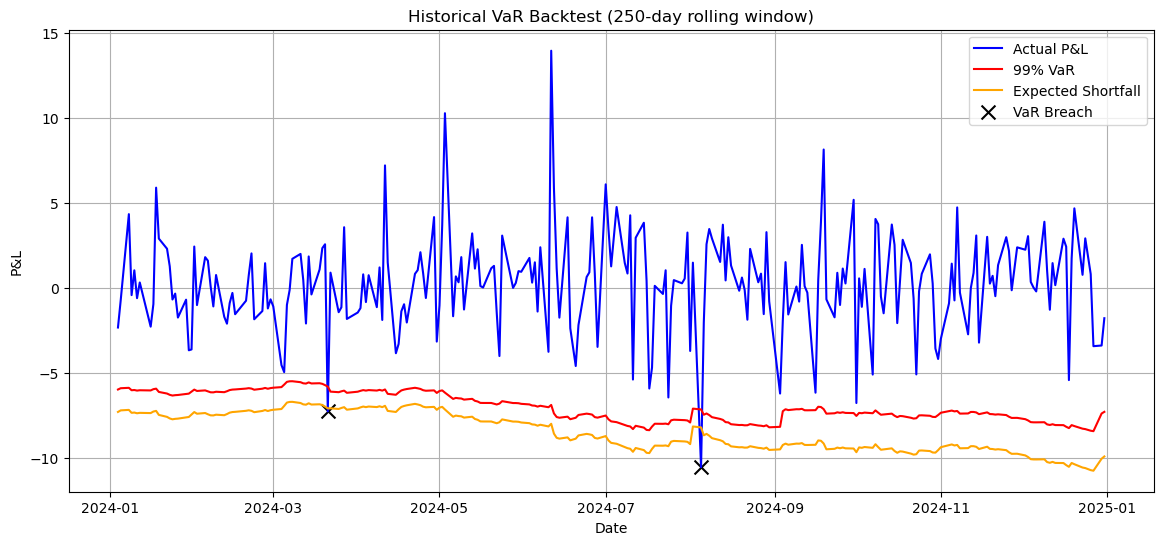

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot actual P&L
plt.plot(backtest_df['Date'], backtest_df['Actual_PnL'], label='Actual P&L', color='blue')

# Plot VaR line
plt.plot(backtest_df['Date'], backtest_df['VaR'], label='99% VaR', color='red')

# Plot Expected Shortfall line
plt.plot(backtest_df['Date'], backtest_df['Expected_Shortfall'], label='Expected Shortfall', color='orange')

# Highlight breaches
breaches = backtest_df[backtest_df['VaR_Breached']]
plt.scatter(breaches['Date'], breaches['Actual_PnL'], color='black', marker='x', s=100, label='VaR Breach')

plt.title('Historical VaR Backtest (250-day rolling window)')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.legend()
plt.grid(True)
plt.show()
